# Accessing Simulation data directly

The Python interface also allows users to access simulation data directly, without requiring file output. In this notebook we repeat the "Two Stream" instability example, but now without any file I/O. The simulation parameters are the same as in the original example, but now we do not define any diagnostics routine:

In [1]:
import em1d

import numpy as np

nx = 120
box = 4 * np.pi
dt = 0.1
tmax = 50.0

ppc = 500
ufl = [0.4,    0.0,  0.0]
uth = [0.001,0.001,0.001]

right = em1d.Species( "right", -1.0, ppc, ufl = ufl, uth = uth )

ufl[0] = -ufl[0]
left  = em1d.Species( "left", -1.0, ppc, ufl = ufl, uth = uth )

# Initialize the simulation without diagnostics
sim = em1d.Simulation( nx, box, dt, [right,left] )

# Run the simulation
sim.run( tmax )


Running simulation up to t = 50 ...
n = 501, t = 50.1
Done.


## Grid data

We can acces the raw electric field, magnetic field and current density data of a `Simulation` object `sim` through the `sim.emf.E`, `sim.emf.B` and `sim.current.J` properties, respectively. Each of these properties will be a [nx, 3] NumPy float32 array that can be used as usual. The last index refers to the field component, so $E_x$ will be `sim.emf.E[:,0]`:

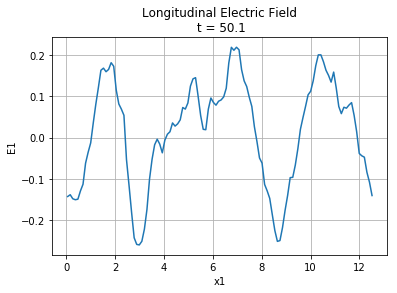

In [2]:
import matplotlib.pyplot as plt

# Plot field values at the center of the cells
xmin = sim.emf.dx/2
xmax = sim.emf.box - sim.emf.dx/2

plt.plot(np.linspace(xmin, xmax, num = sim.nx), sim.emf.E[:,0] )
plt.xlabel("x1")
plt.ylabel("E1")
plt.title("Longitudinal Electric Field\n t = {:g}".format(sim.t))
plt.grid(True)
plt.show()


## Particle data

We can access raw particle data using the `particles` property of each Species object. This property is a NumPy array of `t_part` structures containing:
* `ix` - the particle cell
* `x` - the particle position inside the cell
* `ux`, `uy`, `uz` - the particle generalized velocity in each direction

We can easily use this data to produce the phasespace plot for this simulation. Note that we had to convert the cell index / position to simulation position:

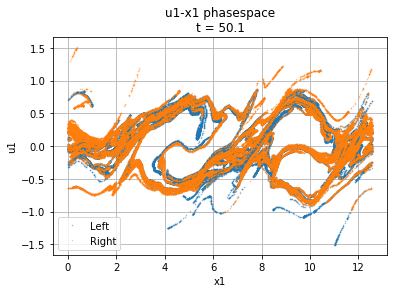

In [3]:
import matplotlib.pyplot as plt

# Simple function to convert particle positions
x = lambda s : (s.particles['ix'] + s.particles['x']) * s.dx 

plt.plot(x(left), left.particles['ux'], '.', ms=1,alpha=0.5, label = "Left")
plt.plot(x(right), right.particles['ux'], '.', ms=1,alpha=0.5, label = "Right")
plt.xlabel("x1")
plt.ylabel("u1")
plt.title("u1-x1 phasespace\nt = {:g}".format(sim.t))
plt.legend()
plt.grid(True)
plt.show()

## Charge Density

Besides the raw simulation data, we can also access diagnostic data that needs to be generated on the fly, such as the charge density. To get the charge density from a `Species` object we use the `charge()` method:

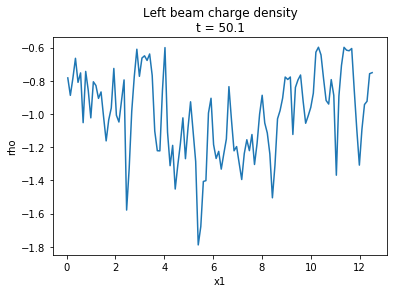

In [4]:
import matplotlib.pyplot as plt

charge = left.charge()

xmin = sim.dx/2
xmax = sim.box - sim.dx/2

plt.plot(np.linspace(xmin, xmax, num = sim.nx), left.charge() ) 
plt.xlabel("x1")
plt.ylabel("rho")
plt.title("Left beam charge density\nt = {:g}".format(sim.t))

plt.show()

## Phasespace Density

Similarily, we can get the phasespace density of a given `Species` object using the `phasespace()` method:  

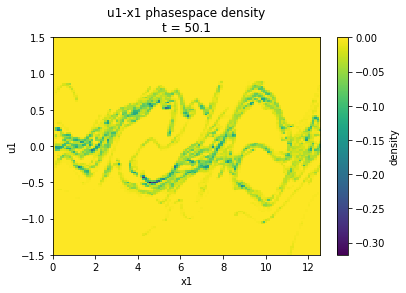

In [6]:
import matplotlib.pyplot as plt

nx    = [120,128]
range = [[0,sim.box],[-1.5,1.5]]
type  = em1d.phasespace( em1d.SpeciesDiag.x1, em1d.SpeciesDiag.u1)

pha = left.phasespace( type, nx, range )

plt.imshow( pha, interpolation = 'nearest', origin = 'lower',
          extent = ( range[0][0], range[0][1], range[1][0], range[1][1] ),
          aspect = 'auto')

plt.colorbar().set_label('density')
plt.xlabel("x1")
plt.ylabel("u1")
plt.title("u1-x1 phasespace density\nt = {:g}".format(sim.t))

plt.show()